In [ ]:
#| default_exp ets

In [ ]:
#| export
import math
import os
import warnings
from collections import namedtuple
from typing import Tuple

import numpy as np
from numba import njit
from statsmodels.tsa.seasonal import seasonal_decompose

# ETS Model

## etscalc

In [ ]:
#| export
# Global variables 
NONE = 0
ADD = 1
MULT = 2
DAMPED = 1
TOL = 1.0e-10
HUGEN = 1.0e10
NA = -99999.0
smalno = np.finfo(float).eps
NOGIL = os.environ.get('NUMBA_RELEASE_GIL', 'False').lower() in ['true']
CACHE = os.environ.get('NUMBA_CACHE', 'False').lower() in ['true']

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def etscalc(y, n, x, m, 
            error, trend, season, 
            alpha, beta, 
            gamma, phi, e, 
            amse, nmse):
    oldb = 0.
    olds = np.zeros(24)
    s = np.zeros(24)
    f = np.zeros(30)
    denom = np.zeros(30)
    if m > 24 and season > NONE:
        return; 
    elif m < 1:
        m = 1 
    if nmse > 30:
        nmse = 30 
    nstates = m * (season > NONE) + 1 + (trend > NONE) 
    #Copy initial state components 
    l = x[0]
    if trend > NONE:
        b = x[1]
    else:
        b = 0.
    if season > NONE:
        for j in range(m):
            s[j] = x[(trend > NONE) + j + 1]
    lik = 0.
    lik2 = 0.
    for j in range(nmse):
        amse[j] = 0.
        denom[j] = 0.
    for i in range(n):
        # Copy previous state
        oldl = l 
        if trend > NONE:
            oldb = b
        if season > NONE:
            for j in range(m):
                olds[j] = s[j]
        # one step forecast 
        forecast(oldl, oldb, olds, m, trend, season, phi, f, nmse)
        if math.fabs(f[0] - NA) < TOL:
            lik = NA
            return lik
        if error == ADD:
            e[i] = y[i] - f[0]
        else:
            e[i] = (y[i] - f[0]) / f[0]
        for j in range(nmse):
            if (i + j) < n:
                denom[j] += 1.
                tmp = y[i + j] - f[j]
                amse[j] = (amse[j] * (denom[j] - 1.0) + (tmp * tmp)) / denom[j]
        # update state
        l, b, s = update(oldl, l, oldb, b, olds, s, m, trend, season, alpha, beta, gamma, phi, y[i])
        # store new state
        x[nstates * (i + 1)] = l 
        if trend > NONE:
            x[nstates * (i + 1) + 1] = b 
        if season > NONE:
            for j in range(m):
                x[nstates * (i + 1) + (trend > NONE) + j + 1] = s[j]
        lik = lik + e[i] * e[i]
        lik2 += math.log(math.fabs(f[0]))
    lik = n * math.log(lik)
    if error == MULT:
        lik += 2 * lik2 
    return lik

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def forecast(l, b, s, m, 
             trend, season, phi, f, h):
    #f is modified and it is mutable
    phistar = phi 
    #forecasts
    for i in range(h):
        #print(phistar)
        if trend == NONE:
            f[i] = l
        elif trend == ADD:
            f[i] = l + phistar * b 
        elif b < 0:
            f[i] = NA
        else:
            f[i] = l * math.pow(b, phistar)
        j = m - 1 - i 
        while j < 0:
            j += m
        if season == ADD:
            f[i] = f[i] + s[j]
        elif season == MULT:
            f[i] = f[i] * s[j]
        if i < h - 1:
            if math.fabs(phi - 1.0) < TOL:
                phistar = phistar + 1.0 
            else:
                phistar = phistar + math.pow(phi, i + 1)

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def update(oldl, l, oldb, b, 
           olds, s, 
           m, trend, season, 
           alpha, beta, gamma, 
           phi, y):
    # New Level 
    if trend == NONE:
        q = oldl            # l(t - 1)
        phib = 0 
    elif trend == ADD:
        phib = phi * oldb
        q = oldl + phib     #l(t - 1) + phi * b(t - 1)
    elif math.fabs(phi - 1.0) < TOL:
        phib = oldb 
        q = oldl * oldb   #l(t - 1) * b(t - 1)
    else:
        phib = math.pow(oldb, phi)
        q = oldl * phib      #l(t - 1) * b(t - 1)^phi
    # season
    if season == NONE:
        p = y 
    elif season == ADD:
        p = y - olds[m - 1]  #y[t] - s[t - m]
    else:
        if math.fabs(olds[m - 1]) < TOL:
            p = HUGEN 
        else:
            p = y / olds[m - 1] #y[t] / s[t - m]
    l = q + alpha * (p - q)
    # New Growth 
    if trend > NONE:
        if trend == ADD:
            r = l - oldl    #l[t] - l[t-1]
        else: #if(trend == MULT)
            if math.fabs(oldl) < TOL:
                r = HUGEN
            else:
                r = l / oldl  #l[t] / l[t-1]
        b = phib + (beta / alpha) * (r - phib) 
        # b[t] = phi*b[t-1] + beta*(r - phi*b[t-1])
        # b[t] = b[t-1]^phi + beta*(r - b[t-1]^phi)
    # New Seasonal
    if season > NONE:
        if season == ADD:
            t = y - q 
        else: #if(season == MULT)
            if math.fabs(q) < TOL:
                t = HUGEN 
            else:
                t = y / q 
        s[0] = olds[m - 1] + gamma * (t - olds[m - 1]) # s[t] = s[t - m] + gamma * (t - s[t - m])
        for j in range(1, m):
            s[j] = olds[j - 1] # s[t] = s[t]
    return l, b, s

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def etssimulate(x, m, error, trend, 
                season, alpha, beta, 
                gamma, phi, h, 
                y, e):
    oldb = 0.
    olds = np.zeros(24)
    s = np.zeros(24)
    f = np.zeros(10)
    if m > 24 and season > NONE:
        return 
    elif m < 1:
        m = 1 
    #nstates = m * (season > NONE) + 1 + (trend > NONE)
    # Copy initial state components 
    l = x[0]
    if trend > NONE:
        b = x[1]
    if season > NONE:
        for j in range(m):
            s[j] = x[(trend > NONE) + j + 1]
    for i in range(h):
        # Copy previous state
        oldl = l 
        if trend > NONE:
            oldb = b 
        if season > NONE:
            for j in range(m):
                olds[j] = s[j]
        # one step forecast
        forecast(oldl, oldb, olds, m, trend, season, phi, f, 1)
        if math.fabs(f[0] - NA) < TOL:
            y[0] = NA
            return 
        if error == ADD:
            y[i] = f[0] + e[i]
        else:
            y[i] = f[0] * (1.0 + e[i])
        # Update state 
        update(oldl, l, oldb, b, olds, s, m, trend, season, alpha, beta, gamma, phi, y[i])

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def etsforecast(x, m, trend, season, 
                phi, h, f):
    s = np.zeros(24)
    if m > 24 and season > NONE:
        return 
    elif m < 1:
        m = 1 
    # Copy initial state components
    l = x[0]
    b = 0.0
    if trend > NONE:
        b = x[1]
    if season > NONE:
        for j in range(m):
            s[j] = x[(trend > NONE) + j + 1]

    # compute forecasts
    forecast(l, b, s, m, trend, season, phi, f, h) 

In [ ]:
#| hide
from statsforecast.utils import AirPassengers as ap

/Users/fedex/projects/statsforecast/statsforecast/core.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
#| hide
nmse_ = len(ap)
amse_ = np.zeros(30)
lik_ = 0.
e_ = np.zeros(len(ap))
alpha = 0.016763333
beta = 0.001766333 
gamma = 0.
phi = 0.
init_states = np.zeros(len(ap) * 2)
init_states[0] = 118.466667
init_states[1] = 2.060606
etscalc(ap, len(ap), 
        init_states, 12, 1, 1, 0, 
        alpha, beta, gamma, phi, 
        e_, amse_, 3)

2070.2270304137664

In [ ]:
#| hide
etscalc(ap, len(ap), 
        init_states, 12, 0, 0, 0, 
        alpha, beta, gamma, phi, 
        e_, amse_, nmse_)

515.6978223742606

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def initparam(alpha: float, beta: float, gamma: float, phi: float, 
              trendtype: str, seasontype: str, 
              damped: bool, 
              lower: np.ndarray, upper: np.ndarray, 
              m: int, bounds: str):
    if bounds == 'admissible':
        lower[:3] = lower[:3] * 0
        upper[:3] = upper[:3] * 0 + 1e-3
    elif (lower > upper).any():
        raise Exception('Inconsistent parameter boundaries')
    #select alpha
    if np.isnan(alpha):
        alpha = lower[0] + 0.2 * (upper[0] - lower[0]) / m
        if alpha > 1 or alpha < 0:
            alpha = lower[0] + 2e-3
    #select beta
    if trendtype != 'N' and np.isnan(beta):
        #ensure beta < alpha
        upper[1] = min(upper[1], alpha)
        beta = lower[1] + 0.1 * (upper[1] - lower[1])
        if beta < 0 or beta > alpha:
            beta = alpha - 1e-3
    #select gamma
    if seasontype != 'N' and np.isnan(gamma):
        upper[2] = min(upper[2], 1 - alpha)
        gamma = lower[2] + 0.05 * (upper[2] - lower[2])
        if gamma < 0 or gamma > 1 - alpha:
            gamma = 1 - alpha - 1e-3
    #select phi
    if damped and np.isnan(phi):
        phi = lower[3] + 0.99 * (upper[3] - lower[3])
        if phi < 0 or phi > 1:
            phi = upper[3] - 1e-3
    return {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'phi': phi}

In [ ]:
#| hide
initparam(alpha=np.nan, beta=np.nan, gamma=np.nan, phi=np.nan, damped=False, 
          trendtype='N', seasontype='N',
          bounds='both', m=12, 
          lower=np.array([0.0001, 0.0001, 0.0001, 0.8]), 
          upper=np.array([0.9999, 0.9999, 0.9999, 0.98]))

DictType[unicode_type,float64]<iv=None>({alpha: 0.016763333333333335, beta: nan, gamma: nan, phi: nan})

In [ ]:
#| exporti
def admissible(alpha: float, beta: float, 
               gamma: float, phi: float, m: int):
    if np.isnan(phi):
        phi = 1
    if phi < 0. or phi > 1 + 1e-8:
        return False
    if np.isnan(gamma):
        if alpha < 1 - 1 / phi or alpha > 1 + 1 / phi:
            return False
        if not np.isnan(beta):
            if beta < alpha * (phi - 1) or beta > (1 + phi) * (2 - alpha):
                return False
    elif m > 1: #seasonal model
        if np.isnan(beta):
            beta = 0
        if gamma < max(1 - 1 / phi - alpha, 0) or gamma > 1 + 1 / phi - alpha:
            return False
        if alpha < 1 - 1 / phi - gamma * (1 - m + phi + phi * m) / (2 * phi * m):
            return False
        if beta < -(1 - phi) * (gamma / m + alpha):
            return False
        # End of easy test. Now use characteristic equation
        P = np.full(2 + m - 2 + 2, fill_value=np.nan)
        P[:2] = np.array([
            phi * (1 - alpha - gamma), 
            alpha + beta - alpha * phi + gamma - 1
        ])
        P[2:(m - 2 + 2)] = np.repeat(alpha + beta - alpha * phi, m - 2)
        P[(m - 2 + 2):] = np.array([alpha + beta - phi, 1])
        roots = np.polynomial.polynomial.polyroots(P)
        zeror = np.real(roots)
        zeroi = np.imag(roots)
        max_ = np.max(np.sqrt(zeror * zeror + zeroi * zeroi))
        if max_ > 1 + 1e-10:
            return False
    # passed all tests
    return True

In [ ]:
#| exporti
def check_param(alpha: float, beta: float, gamma: float, phi: float, 
                lower: np.ndarray, upper: np.ndarray, 
                bounds: str, m: int):
    if bounds != 'admissible':
        if not np.isnan(alpha):
            if alpha < lower[0] or alpha > upper[0]:
                return False
        if not np.isnan(beta):
            if beta < lower[1] or beta > alpha or beta > upper[1]:
                return False
        if not np.isnan(phi):
            if phi < lower[3] or phi > upper[3]:
                return False
        if not np.isnan(gamma):
            if gamma < lower[2] or gamma > 1 - alpha or gamma > upper[2]:
                return False
    if bounds != 'usual':
        if not admissible(alpha, beta, gamma, phi, m):
            return False
    return True

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def sinpi(x):
    return np.sin(np.pi * x)

@njit(nogil=NOGIL, cache=CACHE)
def cospi(x):
    return np.cos(np.pi * x)

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def fourier(x, period, K, h=None):
    if h is None:
        times = np.arange(1, len(x) + 1)
    if h is not None:
        times = np.arange(len(x) + 1, len(x) + h + 1)
    # compute periods of all fourier terms
    # numba doesnt support list comprehension
    len_p = 0
    for k in K:
        if k > 0:
            len_p += k
    p = np.full(len_p, fill_value=np.nan)
    idx = 0
    for j, p_ in enumerate(period):
        if K[j] > 0:
            p[idx:(idx + K[j])] = np.arange(1, K[j] + 1) / period[j]
            idx += K[j]
    p = np.unique(p)
    # Remove columns where sinpi=0
    k = np.abs(2 * p - np.round(2 * p, 0, np.empty_like(p))) > smalno
    # Compute matrix of fourier terms
    X = np.full((len(times), 2 * len(p)), fill_value=np.nan)
    for j in range(len(p)):
        if k[j]:
            X[:, 2 * j - 1] = sinpi(2 * p[j] * times)
        X[:, 2 * j] = cospi(2 * p[j] * times)
    X = X[:, ~np.isnan(X.sum(axis=0))]
    return X

In [ ]:
#| hide
period = 12
fourier_terms = fourier(ap, [period], [1])

/Users/fedex/miniconda3/envs/statsforecast/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'K' of function 'fourier'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../var/folders/7x/1l3vkh3x4_q3s4r36b60s8f00000gn/T/ipykernel_16882/1382665657.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/fedex/miniconda3/envs/statsforecast/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'period' of function 'fourier'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-

In [ ]:
#| exporti
def initstate(y, m, trendtype, seasontype):
    n = len(y)
    if seasontype != 'N':
        if n < 4:
            raise ValueError("You've got to be joking (not enough data).")
        elif n < 3 * m: #fit simple Fourier model
            fouriery = fourier(y, [m], [1])
            X_fourier = np.full((n, 4), fill_value=np.nan)
            X_fourier[:, 0] = np.ones(n)
            X_fourier[:, 1] = np.arange(1, n + 1)
            X_fourier[:, 2:4] = fouriery
            coefs, *_ = np.linalg.lstsq(X_fourier, y, rcond=-1)
            if seasontype == 'A':
                y_d = dict(seasonal=y - coefs[0] - coefs[1] * X_fourier[:, 1])
            else:
                if not min(y) > 0:
                    raise Exception(
                        'Multiplicative seasonality is not appropriate for zero and negative values'
                    )
                y_d = dict(seasonal=y/(coefs[0] + coefs[1] * X_fourier[:, 1]))
        else:
            #n is large enough to do a decomposition
            y_d = seasonal_decompose(y, period=m, model='additive' if seasontype == 'A' else 'multiplicative')
            y_d = dict(seasonal=y_d.seasonal)
        init_seas = y_d['seasonal'][1:m][::-1]
        if seasontype == 'A':
            y_sa = y - y_d['seasonal']
        else:
            init_seas = np.clip(init_seas, a_min=1e-2, a_max=None)
            if init_seas.sum() > m:
                init_seas = init_seas / np.sum(init_seas + 1e-2)
            y_sa = y / np.clip(y_d['seasonal'], a_min=1e-2, a_max=None)
    else:
        m = 1
        init_seas = []
        y_sa = y
    maxn = min(max(10, 2 * m), len(y_sa))
    if trendtype == 'N':
        l0 = y_sa[:maxn].mean()
        b0 = None
        return np.concatenate([[l0], init_seas])
    else: # simple linear regression on seasonally adjusted data
        X = np.full((n, 2), fill_value=np.nan)
        X[:, 0] = np.ones(n) 
        X[:, 1] = np.arange(1, n + 1)
        (l, b), *_ = np.linalg.lstsq(X[:maxn], y_sa[:maxn], rcond=-1)
        if trendtype == 'A':
            l0 = l
            b0 = b
            # if error type is M then we dont want l0+b0=0
            # so perturb just in case
            if abs(l0 + b0) < 1e-8:
                l0 = l0 * (1 + 1e-3)
                b0 = b0 * (1 - 1e-3)
        else:
            l0 = l + b
            if abs(l0) < 1e-8:
                l0 = 1e-7
            b0 = (l + 2 * b) / l0
            if math.isclose(b0, 0.0, abs_tol=1e-8):
                div = 1e-8
            else:
                div = b0
            l0 = l0 / div
            if abs(b0) > 1e10:
                b0 = np.sign(b0) * 1e10
            if l0 < 1e-8 or b0 < 1e-8: # simple linear approximation didnt work
                l0 = max(y_sa[0], 1e-3)
                if math.isclose(y_sa[0], 0.0, abs_tol=1e-8):
                    div = 1e-8
                else:
                    div = y_sa[0]
                b0 = max(y_sa[1] / div, 1e-3)
    return np.concatenate([[l0, b0], init_seas])

In [ ]:
#| hide
initstate(ap, 12, 'A', 'A')

array([121.30970026,   0.94855731, -28.61994949, -53.59343434,
       -20.64267677,  16.52020202,  62.82323232,  63.83080808,
        35.40277778,  -4.50631313,  -8.03661616,  -2.24116162,
       -36.18813131])

In [ ]:
#| hide
initstate(np.zeros(10), 1, 'M', 'A')
initstate(np.zeros(10), 1, 'A', 'A')

array([0., 0.])

In [ ]:
#| hide
initstate(np.zeros(12*3), 12, 'M', 'A')
initstate(np.zeros(12*3), 12, 'A', 'A')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def switch(x: str):
    return {'N': 0, 'A': 1, 'M': 2}[x]

In [ ]:
#| hide
switch('A')

1

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def pegelsresid_C(y: np.ndarray, 
                  m: int, 
                  init_state: np.ndarray, 
                  errortype: str, 
                  trendtype: str, 
                  seasontype: str, 
                  damped: bool, 
                  alpha: float, beta: float, gamma: float, phi: float, 
                  nmse: int):
    n = len(y)
    p = len(init_state)
    x = np.full(p * (n + 1), fill_value=np.nan)
    x[:p] = init_state
    e = np.full_like(y, fill_value=np.nan)
    if not damped:
        phi = 1.
    if trendtype == 'N':
        beta = 0.
    if seasontype == 'N':
        gamma = 0.
    amse = np.full(nmse, fill_value=np.nan)
    lik = etscalc(y=y, n=n, x=x, m=m, 
                  error=switch(errortype),
                  trend=switch(trendtype), 
                  season=switch(seasontype),
                  alpha=alpha, beta=beta, gamma=gamma, phi=phi,
                  e=e, amse=amse, nmse=nmse)
    x = x.reshape((n + 1, p))
    if not np.isnan(lik):
        if np.abs(lik + 99999) < 1e-7:
            lik = np.nan
    return amse, e, x, lik

In [ ]:
#| exporti
results = namedtuple('results', 'x fn nit simplex')

@njit(nogil=NOGIL, cache=CACHE)
def restrict_to_bounds(x, lower, upper):
    new_x = np.full_like(x, fill_value=np.nan, dtype=x.dtype)
    for i in range(x.size):
        lo = lower[i]
        up = upper[i]
        if x[i] < lo:
            new_x[i] = lo
        elif x[i] > up:
            new_x[i] = up
        else:
            new_x[i] = x[i]
    return new_x
            
@njit(nogil=NOGIL, cache=CACHE)
def nelder_mead(
        fn, 
        x0: np.ndarray, 
        args: Tuple = (), 
        lower: np.ndarray = np.empty(0), 
        upper: np.ndarray = np.empty(0), 
        init_step: float = 0.05,
        zero_pert: float = 0.0001,
        alpha: float = 1.,
        gamma: float = 2.,
        rho: float = 0.5,
        sigma: float = 0.5,
        max_iter: int = 2_000,
        tol_std: float = 1e-10,
        adaptive: bool = False,
    ):
    #We are trying to minimize the function fn(x, args)
    #with initial point x0.
    #Step 0:
    # get x1, ..., x_{n+1}
    # the original article suggested a simplex where an initial point is given as x0
    # with the others generated with a fixed step along each dimension in turn.
    bounds = len(lower) and len(upper)
    if bounds:
        x0 = restrict_to_bounds(x0, lower, upper)
    
    n = x0.size
    if adaptive:
        gamma = 1. + 2. / n
        rho = 0.75 - 1. / (2. * n)
        sigma = 1. - 1. / n
    simplex = np.full((n + 1, n), fill_value=np.nan, dtype=np.float64) #each row is x_j
    simplex[:] = x0
    # perturb simplex using `init_step`
    diag = np.copy(np.diag(simplex))
    diag[diag == 0.] = zero_pert
    diag[diag != 0.] *= (1 + init_step)
    np.fill_diagonal(simplex, diag)
    # restrict simplex to bounds if passed
    if bounds:
        for j in range(n + 1):
            simplex[j] = restrict_to_bounds(simplex[j], lower, upper)
    # array of the value of f
    f_simplex = np.full(n + 1, fill_value=np.nan)
    for j in range(n + 1):
        f_simplex[j] = fn(simplex[j], *args)
    for it in range(max_iter):
        #Step1: order of f_simplex
        #print(simplex)
        #print(f_simplex)
        order_f = f_simplex.argsort()
        best_idx = order_f[0]
        worst_idx = order_f[-1]
        second_worst_idx = order_f[-2]
        #Check whether method should stop.
        if np.std(f_simplex) < tol_std:
            break
        #calculate centroid except argmax f_simplex
        x_o = simplex[np.delete(order_f, -1)].sum(axis=0) / n
        #Step2: Reflection, Compute reflected point
        x_r = x_o + alpha * (x_o - simplex[worst_idx])
        # restrict x_r to bounds if passed
        if bounds:
            x_r = restrict_to_bounds(x_r, lower, upper)
        f_r = fn(x_r, *args)
        if f_simplex[best_idx] <= f_r < f_simplex[second_worst_idx]:
            simplex[worst_idx] = x_r
            f_simplex[worst_idx] = f_r
            continue
        #Step3: Expansion, reflected point is the best point so far
        if f_r < f_simplex[best_idx]:
            x_e = x_o + gamma * (x_r - x_o)
            # restrict x_e to bounds if passed
            if bounds:
                x_e = restrict_to_bounds(x_e, lower, upper)
            f_e = fn(x_e, *args)
            if f_e < f_r:
                simplex[worst_idx] = x_e
                f_simplex[worst_idx] = f_e
            else:
                simplex[worst_idx] = x_r
                f_simplex[worst_idx] = f_r
            continue
        #Step4: outside Contraction
        if f_simplex[second_worst_idx] <= f_r < f_simplex[worst_idx]:
            x_oc = x_o + rho * (x_r - x_o)
            if bounds:
                x_oc = restrict_to_bounds(x_oc, lower, upper)
            f_oc = fn(x_oc, *args)
            if f_oc <= f_r:
                simplex[worst_idx] = x_oc
                f_simplex[worst_idx] = f_oc
                continue
        #step 5 inside contraction
        else:
            x_ic = x_o - rho * (x_r - x_o)
            # restrict x_c to bounds if passed
            if bounds:
                x_ic = restrict_to_bounds(x_ic, lower, upper)
            f_ic = fn(x_ic, *args)
            if f_ic < f_simplex[worst_idx]:
                simplex[worst_idx] = x_ic
                f_simplex[worst_idx] = f_ic
                continue
        #step 6: shrink
        simplex[np.delete(order_f, 0)] = simplex[best_idx] + sigma * (simplex[np.delete(order_f, 0)] - simplex[best_idx])
        for i in np.delete(order_f, 0):
            simplex[i] = restrict_to_bounds(simplex[i], lower, upper)
            f_simplex[i] = fn(simplex[i], *args)
    return results(simplex[best_idx], f_simplex[best_idx], it + 1, simplex)

In [ ]:
#| export
@njit(nogil=NOGIL, cache=CACHE)
def ets_target_fn(
        par,
        p_y, p_nstate, 
        p_errortype, p_trendtype, p_seasontype, p_damped, 
        p_lower, p_upper, p_opt_crit, p_nmse, p_bounds, p_m, 
        p_optAlpha, p_optBeta, p_optGamma, p_optPhi, 
        p_givenAlpha, p_givenBeta, p_givenGamma, p_givenPhi, 
        alpha, beta, gamma, phi
    ):
    #p_par_length = len(par)
    j = 0 
    if p_optAlpha: 
        alpha = par[j]
        j += 1
    if p_optBeta:
        beta = par[j]
        j += 1
    if p_optGamma:
        gamma = par[j]
        j += 1
    if p_optPhi:
        phi = par[j]
    #size of state
    p = p_nstate + (1 if p_seasontype != 0 else 0)
    n = len(p_y)
    state = np.zeros(p * (n + 1))
    state[:p_nstate] = par[-p_nstate:]
    # Add extra state
    if p_seasontype != 0:
        start = 1 + (1 if p_trendtype != 0 else 0)
        sum_ = state[start:p_nstate].sum()
        new_state = p_m * (1 if p_seasontype == 2 else 0) - sum_
        state[p_nstate] = new_state
    # check states 
        if p_seasontype == 2 and state[start:].min() < 0:
            return np.inf
    amse = np.zeros(30)
    e = np.zeros(n)
    lik = etscalc(
        #we dont need to change these param
        p_y, n, state, p_m, 
        p_errortype, p_trendtype, p_seasontype, 
        #inmutable, wee need to change them?
        alpha, beta, gamma, phi, 
        #mutable
        e, amse, 
        #inmutable
        p_nmse
    )
    if lik < -1e10: 
        lik = -1e10 
    if math.isnan(lik): 
        lik = -np.inf
    if math.fabs(lik + 99999) < 1e-7: 
        lik = -np.inf
    if p_opt_crit == "lik":
        objval = lik 
    elif p_opt_crit == "mse": 
        objval = amse[0]
    elif p_opt_crit == "amse":
        mean = 0.
        for i in range(p_nmse):
            mean += amse[i] / p_nmse 
        objval = mean 
    elif p_opt_crit == "sigma":
        mean = 0.
        ne = len(e)
        for i in range(ne):
            mean += e[i] * e[i] / ne 
        objval = mean 
    elif p_opt_crit == "mae":
        mean = 0
        ne = len(e)
        for i in range(ne):
            mean += math.fabs(e[i]) / ne 
        objval = mean
    return objval

In [ ]:
#| exporti
def optimize_ets_target_fn(
        x0, par, y, nstate, 
        errortype, trendtype, seasontype, damped, 
        par_noopt, lowerb, upperb, opt_crit, 
        nmse, bounds, m, pnames, pnames2
    ):
    alpha = par_noopt['alpha'] if np.isnan(par['alpha']) else par['alpha']
    if np.isnan(alpha):
        raise ValueError('alpha problem!')
    if trendtype != 'N':
        beta = par_noopt['beta'] if np.isnan(par['beta']) else par['beta']
        if np.isnan(beta):
            raise ValueError('beta problem!')
    else:
        beta = np.nan
    if seasontype != 'N':
        gamma = par_noopt['gamma'] if np.isnan(par['gamma']) else par['gamma']
        if np.isnan(gamma):
            raise ValueError('gamma problem!')
    else:
        m = 1
        gamma = np.nan
    if damped:
        phi = par_noopt['phi'] if np.isnan(par['phi']) else par['phi']
        if np.isnan(phi):
            raise ValueError('phi problem!')
    else:
        phi = np.nan
        
    optAlpha = not np.isnan(alpha)
    optBeta = not np.isnan(beta)
    optGamma = not np.isnan(gamma)
    optPhi = not np.isnan(phi)
    
    givenAlpha = False
    givenBeta = False
    givenGamma = False
    givenPhi = False
    
    if not np.isnan(par_noopt['alpha']):
        optAlpha = False
        givenAlpha = True
    if not np.isnan(par_noopt['beta']):
        optBeta = False
        givenBeta = True
    if not np.isnan(par_noopt['gamma']):
        optGamma = False
        givenGamma = True
    if not np.isnan(par_noopt['phi']):
        optPhi = False
        givenPhi = True
    
    if not damped:
        phi = 1.
    if trendtype == 'N':
        beta = 0.
    if seasontype == 'N':
        gamma = 0.
    res = nelder_mead(
        ets_target_fn, x0, 
        args=(
            y, nstate, switch(errortype), switch(trendtype), switch(seasontype),
            damped, lowerb, upperb, opt_crit, nmse, bounds, m, 
            optAlpha, optBeta, optGamma, optPhi, 
            givenAlpha, givenBeta, givenGamma, givenPhi,
            alpha, beta, gamma, phi
        ),
        lower=lowerb,
        upper=upperb,
        tol_std=1e-4, 
        max_iter=1_000,
        adaptive=True,
    )
    return res

In [ ]:
#| exporti
def etsmodel(y: np.ndarray, m: int, 
             errortype: str, trendtype: str, seasontype: str, 
             damped: bool,
             alpha: float, beta: float, gamma: float, 
             phi: float, lower: np.ndarray, upper: np.ndarray, 
             opt_crit: str,
             nmse: int, bounds: str, maxit: int = 2_000,
             control=None, seed=None, trace: bool = False):
    if seasontype == 'N':
        m = 1
    #if not np.isnan(alpha):
    #    upper[2] = min(alpha, upper[2])
    #    upper[3] = min(1 - alpha, upper[3])
    #if not np.isnan(beta):
    #    lower[1] = max(beta, lower[1])
    #    upper[1] = min(1 - gamma, upper[1])
    par_ = initparam(alpha, beta, gamma, phi, trendtype, 
                    seasontype, damped, lower, upper, m, bounds)
    par_noopt = dict(alpha=alpha, beta=beta, gamma=gamma, phi=phi)
    
    if not np.isnan(par_['alpha']):
        alpha = par_['alpha']
    if not np.isnan(par_['beta']):
        beta = par_['beta']
    if not np.isnan(par_['gamma']):
        gamma = par_['gamma']
    if not np.isnan(par_['phi']):
        phi = par_['phi']
    if not check_param(alpha, beta, gamma, phi, lower, upper, bounds, m):
        raise Exception('Parameters out of range')
    #initialize state
    init_state = initstate(y, m, trendtype, seasontype)
    nstate = len(init_state)
    par_ = {key: val for key, val in par_.items() if not np.isnan(val)}
    par = np.full(len(par_) + nstate, fill_value=np.nan)
    par[:len(par_)] = list(par_.values())
    par[len(par_):] = init_state
    lower_ = np.full_like(par, fill_value=-np.inf)
    upper_ = np.full_like(par, fill_value=np.inf)
    j = 0
    for i, pr in enumerate(['alpha', 'beta', 'gamma', 'phi']):
        if pr in par_.keys():
            lower_[j] = lower[i]
            upper_[j] = upper[i]
            j += 1
    lower = lower_
    upper = upper_
    np_ = len(par)
    if np_ >= len(y) - 1:
        return dict(aic=np.inf, bic=np.inf, aicc=np.inf, mse=np.inf,
                    amse=np.inf, fit=None, par=par, states=init_state)
    
    fred = optimize_ets_target_fn(
        x0=par, par=par_, y=y, nstate=nstate, 
        errortype=errortype, trendtype=trendtype,
        seasontype=seasontype, damped=damped, 
        par_noopt=par_noopt, lowerb=lower, upperb=upper,
        opt_crit=opt_crit, 
        nmse=nmse, 
        bounds=bounds, m=m, 
        pnames=par_.keys(), 
        pnames2=par_noopt.keys()
    )
    fit_par = fred.x
    init_state = fit_par[-nstate:]
    if seasontype != 'N':
        init_state = np.hstack([
            init_state,
            m * (seasontype == "M") - init_state[(1 + (trendtype != "N")):nstate].sum()
        ])
    j = 0
    if not np.isnan(fit_par[j]):
        alpha = fit_par[j]
        j += 1
    if trendtype != 'N': 
        if not np.isnan(fit_par[j]):
            beta = fit_par[j]
        j += 1
    if seasontype != 'N':
        if not np.isnan(fit_par[j]):
            gamma = fit_par[j]
        j += 1
    if damped:
        if not np.isnan(fit_par[j]):
            phi = fit_par[j]
        
    amse, e, states, lik = pegelsresid_C(
        y, m, init_state, 
        errortype, trendtype, seasontype, damped, 
        alpha, beta, gamma, phi, nmse
    )
    np_ = np_ + 1
    ny = len(y)
    aic = lik + 2 * np_
    bic = lik + np.log(ny) * np_
    if ny - np_ - 1 != 0.:
        aicc = aic + 2 * np_ * (np_ + 1) / (ny - np_ - 1)
    else:
        aicc = np.inf
    
    mse = amse[0]
    amse = np.mean(amse)
    
    fit_par = np.concatenate([[alpha, beta, gamma, phi], init_state])
    if errortype == 'A':
        fits = y - e
    else:
        fits = y / (1 + e)
    
    return dict(loglik=-0.5 * lik, aic=aic, bic=bic, aicc=aicc,
                mse=mse, amse=amse, fit=fred, residuals=e,
                components=f"{errortype}{trendtype}{seasontype}{'D' if damped else 'N'}",
                m=m, nstate=nstate,
                fitted=fits, states=states, par=fit_par)

In [ ]:
#| hide
res = etsmodel(
    y=ap[-20:], m=1, errortype='A', trendtype='A', seasontype='N',
    damped=True, 
    alpha=np.nan, 
    beta=np.nan, 
    gamma=np.nan, 
    phi=np.nan, 
    lower=np.array([0.0001, 0.0001, 0.0001, 0.8]), 
    upper=np.array([0.9999, 0.9999, 0.9999, 0.98]), 
    opt_crit='lik', nmse=3,
    bounds='both', maxit=100)

In [ ]:
#| exporti
def ets_f(y, m, model='ZZZ', 
          damped=None, alpha=None, beta=None, gamma=None, phi=None,
          additive_only=None, blambda=None, biasadj=None, 
          lower=np.array([0.0001, 0.0001, 0.0001, 0.8]), 
          upper=np.array([0.9999, 0.9999, 0.9999, 0.98]),
          opt_crit='lik', nmse=3, bounds='both',
          ic='aicc', restrict=True, allow_multiplicative_trend=False,
          use_initial_values=False, 
          maxit=2_000):
    # converting params to floats 
    # to improve numba compilation
    if alpha is None:
        alpha = np.nan
    if beta is None:
        beta = np.nan
    if gamma is None:
        gamma = np.nan
    if phi is None:
        phi = np.nan
    if blambda is not None:
        raise NotImplementedError('`blambda` not None')
    if nmse < 1 or nmse > 30:
        raise ValueError('nmse out of range')
    if any(upper < lower):
        raise ValueError('Lower limits must be less than upper limits')
    #refit model not implement yet
    errortype, trendtype, seasontype = model
    if errortype not in ['M', 'A', 'Z']:
        raise ValueError('Invalid error type')
    if trendtype not in ['N', 'A', 'M', 'Z']:
        raise ValueError('Invalid trend type')
    if seasontype not in ['N', 'A', 'M', 'Z']:
        raise ValueError('Invalid season type')
    if m < 1 or len(y) <= m:
        seasontype = 'N'
    if m == 1:
        if seasontype == 'A' or seasontype == 'M':
            raise ValueError('Nonseasonal data')
        else:
            #model[3] = 'N'
            seasontype = 'N'
    if m > 24:
        if seasontype in ['A', 'M']:
            raise ValueError('Frequency too high')
        elif seasontype == 'Z':
            warnings.warn(
                "I can't handle data with frequency greater than 24. " 
                "Seasonality will be ignored."
            )
            #model[3] = 'N'
            seasontype = 'N'
    if restrict:
        if (errortype == 'A' and (trendtype == 'M' or seasontype == 'M')) \
            or (errortype == 'M' and trendtype == 'M' and seasontype == 'A') \
            or (additive_only and (errortype == 'M' or trendtype == 'M' or seasontype == 'M')):
            raise ValueError('Forbidden model combination')
    data_positive = min(y) > 0
    if (not data_positive) and errortype == 'M':
        raise ValueError('Inappropriate model for data with negative or zero values')
    if damped is not None:
        if damped and trendtype=='N':
            ValueError('Forbidden model combination')
    n = len(y)
    npars = 2 # alpha + l0
    if trendtype in ['A', 'M']:
        npars += 2 #beta + b0
    if seasontype in ['A', 'M']:
        npars += 2 # gamma + s
    if damped is not None:
        npars += damped
    #ses for non-optimized tiny datasets
    if n <= npars + 4:
        #we need HoltWintersZZ function
        raise NotImplementedError('tiny datasets')
    # fit model (assuming only one nonseasonal model)
    if errortype == 'Z':
        errortype = ['A', 'M']
    if trendtype == 'Z':
        trendtype = ['N', 'A']
        if allow_multiplicative_trend:
             trendtype += ['M']
    if seasontype == 'Z':
        seasontype = ['N', 'A', 'M']
    if damped is None:
        damped = [True, False]
    else:
        damped = [damped]
    best_ic = np.inf
    for etype in errortype:
        for ttype in trendtype:
            for stype in seasontype:
                for dtype in damped:
                    if ttype == 'N' and dtype:
                        continue
                    if restrict:
                        if etype == 'A' and (ttype == 'M' and stype == 'M'):
                            continue
                        if etype == 'M' and ttype == 'M' and stype == 'A':
                            continue
                        if additive_only and (etype == 'M' or ttype == 'M' or stype == 'M'):
                            continue
                    if (not data_positive) and etype == 'M':
                        continue
                    if stype != 'N' and m == 1:
                        continue
                    fit = etsmodel(y, m, etype, ttype, stype, dtype,
                                   alpha, beta, gamma, phi,
                                   lower=lower, upper=upper, opt_crit=opt_crit,
                                   nmse=nmse, bounds=bounds, 
                                   maxit=maxit)
                    fit_ic = fit[ic]
                    print(etype, ttype, stype, stype, fit_ic)
                    if not np.isnan(fit_ic):
                        if fit_ic < best_ic:
                            model = fit
                            best_ic = fit_ic
                            best_e = etype
                            best_t = ttype
                            best_s = stype
                            best_d = dtype
    if np.isinf(best_ic):
        raise Exception('no model able to be fitted')
    model['method'] = f"ETS({best_e},{best_t}{'d' if best_d else ''},{best_s})"
    return model

In [ ]:
#| exporti
def pegelsfcast_C(h, obj, npaths=None, level=None, bootstrap=None):
    forecast = np.full(h, fill_value=np.nan)
    states = obj['states'][-1,:]
    etype, ttype, stype = [switch(comp) for comp in obj['components'][:3]]
    phi = 1 if obj['components'][3] == 'N' else obj['par'][3]
    m = obj['m']
    etsforecast(x=states, m=m, trend=ttype, season=stype, 
                phi=phi, h=h, f=forecast)
    return forecast

In [ ]:
#| exporti
def forecast_ets(obj, h):
    fcst = pegelsfcast_C(h, obj)
    out = {'mean': fcst}
    out['residuals'] = obj['residuals']
    out['fitted'] = obj['fitted']
    return out

A N N N 1733.9581671475883
A A N N 1740.0303810995283
A A N N 1737.59990676879
M N N N 1674.0716308283093
M A N N 1677.8083117772346
M A N N 1673.411490927854


[<matplotlib.lines.Line2D>]

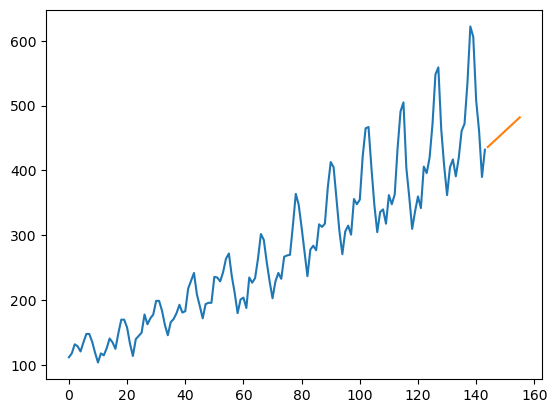

In [ ]:
#| hide
import matplotlib.pyplot as plt
res = ets_f(ap, m=1)
fcst = forecast_ets(res, 12)
plt.plot(np.arange(0, len(ap)), ap)
plt.plot(np.arange(len(ap), len(ap) + 12), fcst['mean'])

In [ ]:
#| hide
ets_f(np.zeros(10), m=12)

A N N N -inf
A A N N -inf
A A N N -inf


Exception: no model able to be fitted